<h1 style="color:rgb(0,120,170)">Assignment 5: CharRNN (using PyTorch)</h1>
Build an character level LSTM using pytorch but without using the built in LSTM.

Test and train-set: https://github.com/ryanmcdermott/trump-speeches

In [1]:
# %load_ext line_profiler # for prun/lprun
%matplotlib inline
import re
import os
from pathlib import Path, PosixPath
from typing import Tuple
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multinomial import Multinomial
from functools import partial

# use gpu if you can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<h2 style="color:rgb(0,120,170)">Dataloader and preprocessing</h2>

As most chars are irrelevant and the training set includes multiple uncommon unicode signs (often just once), this blows up the network size. To simplify training, do some character-level-preprocessing, so that the one-hot encoded representation is smaller.

In [2]:
REPLACE = {"”": '"', "“":'"', "$": "", "—": "-", "–": "-", "é":"e", "…": "...", "‘": '"', "’": "'", 
           "%": "percent", "@": "at", ";": ",", "/": " or ", "_": "", "=": ""}

class Transcoder():
    """ The TextDS shouldn't contain encoders, as it is transferred to multiple dataloader processes """
    def __init__(self, text_file: PosixPath):
        data = open(text_file, encoding="utf-8").read()
        data = self.preprocess(data)  # encoding on windows isn't utf-8
        self.decoder = sorted(set(data))
        encoder = {s: i for i, s in enumerate(self.decoder)}
        # if sign wasn't in training set, replace it with " " in encode
        self.encoder = defaultdict(lambda: encoder[" "], encoder)
        print(f"Created en/de-coder for {text_file} with {len(self.decoder)} letters")

    def decode(self, data: list) -> str:
        return "".join([self.decoder[d] for d in data])
    
    def encode(self, data: str) -> np.ndarray:  # slicing on np arrays is easier 
        return np.array([self.encoder[d] for d in data], dtype=np.byte)
        
    def preprocess(self, data: str) -> str:
        data = data.lower()  # 50% less letters -> 50% less computing. and it's bad in the original anyways
        data = re.sub("\(.+\)", "", data)  # i.e. (CHEERS)
        data = re.sub("\[.+\]", "", data)  # i.e. [SILENCE]
        data = re.sub(r"\d\d?/\d\d?/\d\d\d\d", "", data)  # i.e. 7/11/2016, has to be before letter-replacer
        data = re.sub(r"q&a", "", data)  # trash that appears once and adds an &
        data = re.sub(r"speech \d\n", "", data)  # i.e. SPEECH 1
        # replace letters with static replace-map, normally we'd use unicodedata.normalize
        data = "".join([REPLACE[letter] if letter in REPLACE else letter for letter in data])
        data = re.sub(r"\n+", "\n", data)
        # debug option: show all remaining chars and their charcodes
        # print({ord(d): d for d in sorted(set(data)-set("abcdefghijklmnopqrstuvwxyz0123456789"))})
        return data.strip()
        

class TextDS(Dataset):
    def __init__(self, text_file: PosixPath, seq_length: int, transcoder: Transcoder, use_wordstarts=True):
        data = transcoder.preprocess(open(text_file, encoding="utf-8").read())  # encoding on windows isn't utf-8
        self.seq_length = seq_length
        self.data = transcoder.encode(data)
        if use_wordstarts:
            self.wordstarts = [match.start()+1 for match in re.finditer("[ \n]+", data)]
            self.wordstarts = [0] + list(filter(lambda a: a < len(data) - seq_length, self.wordstarts))
        else: # yields more samples but longer training time
            self.wordstarts = range(len(data) - seq_length)
        print(f"Created dataloader for {text_file} with {len(self.wordstarts)} samples.")
        # load all tensors into gpu once
        self.items = [(tensor(self.data[self.wordstarts[idx]:self.wordstarts[idx]+self.seq_length], dtype=torch.int64).to(device), 
                tensor(self.data[  self.wordstarts[idx]+self.seq_length], dtype=torch.int64).to(device))
                      for idx in range(len(self.wordstarts))]
        
    def __len__(self) -> int:  # all possible slices
        return len(self.wordstarts)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.items[idx]

<h2 style="color:rgb(0,120,170)">The pytorch model</h2>

Unlike numpy, we don't need a backward pass, as pytorch can automatically do this with autograd, so we only need the forward-formulas from the last exercise.

This version of the model also has variables for the initialization (init0) and activation functions, as various versions of LSTMs can have different variants.

In [3]:
class Model(nn.Module):
    def __init__(self, n_cells: int, n_output: int, **kwargs):
        super(Model, self).__init__()
        # we don't need n_input, as torch is cool enough to handle variable length sequences just fine
        self.n_cells = n_cells   # hidden size
        self.n_output = n_output # alphabet size
        
        # input connections
        self.i, self.o, self.z = [nn.Linear(self.n_output, self.n_cells) for _ in range(3)]
        # recurrent connections, without bias as we allready have the additive bias from input connections
        self.ri, self.ro, self.rz = [nn.Linear(self.n_cells, self.n_cells, bias=False) for _ in range(3)]
        # output connection
        self.v = nn.Linear(self.n_cells, self.n_output)
        # activation functions
        self.a0, self.a1, self.a2 = [nn.Sigmoid(), nn.Tanh(), nn.Softmax((1))]  # softmax on dim 2
        # previous initializations
        self.init0 = torch.zeros(self.n_cells).to(device)
        
        
    def forward(self, inp: torch.Tensor, **kwargs) -> torch.Tensor:
        batch_size, n_input = inp.shape
        oh = nn.functional.one_hot(inp, self.n_output).float()
        
        # init recurrent stuff with 0
        i = o = z = c = self.init0
        # actual LSTM logic
        for index in range(n_input):
            t = oh[:,index,:]
            i = self.a0(self.i(t) + self.ri(i))
            o = self.a0(self.o(t) + self.ro(o))
            z = self.a1(self.o(t) + self.rz(z))
            c = c + i * z
            h = o * self.a1(c)
        return self.a2(self.v(h))

<h2 style="color:rgb(0,120,170)">Training and evaluation loop</h2>

To train the model above, we need a classic data loading setup as well as a training loop. This can also be used for hyperparameter search, and the most popular hyperparameters like  epochs, word_len, batch_size, number of lstm cells, learning rate....) are already parameters to ease hyperparameter search. However, most parameters here are rather big, and further hyperparameter search could increase the training times by orders of magnitude.

Different kinds of data and setups may additionally require different optimizers, encodings, activation functions...

Due to our dataloader setup, we even have a reduced and an extended dataset. To speed up learning, we do pretraining with the reduced set and then do a fine tuning iteration with a smaller learning rate.

Progress is visualized with the tqdm module, history is tracked in a [2, epochs] np array.

In [4]:
NET_NAME = "trump.torch.net"

def train(train_file: PosixPath, val_file: PosixPath, 
          epochs: int, word_len: int, batch_size: int, lstm_cells: int, lr: int, use_wordstarts=True, net=None):
    # data loaders
    transcoder = Transcoder(train_file)
    n_signs = len(transcoder.decoder)
    train_dataset = TextDS(train_file, word_len, transcoder, use_wordstarts=use_wordstarts)
    val_dataset   = TextDS(val_file,   word_len, transcoder, use_wordstarts=use_wordstarts)
    # use 1 worker only, because windows can't pickle lambdas/gives a broken pipe
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)
    print("preprocessing done")
    
    # init net parameters
    if not net:
        net = Model(n_cells = lstm_cells, n_output=n_signs).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    progress = tqdm(range(epochs), unit="ep")
    history = []
    
    # training loop, visualized with tqdm
    for epoch in progress:  # epoch loop
        # training loop
        tloss, vloss = 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            labels = nn.functional.one_hot(labels, n_signs).float()
            loss = criterion(outputs, labels)
            tloss += loss.item()  # type conversion + unpacking from tensor to float
            loss.backward()
            optimizer.step()
            
        # validation
        for inputs, labels in val_loader:
            outputs = net(inputs)
            labels = nn.functional.one_hot(labels, n_signs).float()
            loss = criterion(outputs, labels)
            vloss += loss.item()
        
        progress.set_postfix(tloss=tloss, vloss=vloss, refresh=False)
        history.append((tloss/len(train_loader), vloss/len(val_loader)))  # length-normalized loss
    return net, transcoder, np.array(history).T

# pretrain with 100 epochs, use_wordstarts=True, word_len of 25 (less data, 30s /ep)
net, transcoder, history0 = train("trump_train.txt", "trump_val.txt", epochs=100, word_len=25, batch_size=1024, lstm_cells=100, lr=0.01, use_wordstarts=True)
# torch.save(net, NET_NAME)
# finetune with 21 epochs, use_wordstarts=False, word_len of 50 (more data, 300s/ep)
net, transcoder, history1 = train("trump_train.txt", "trump_val.txt", epochs=21 , word_len=50, batch_size=1024, lstm_cells=100, lr=0.001, use_wordstarts=False, net=net)
# torch.save(net, NET_NAME+".finetuned")

Created en/de-coder for trump_train.txt with 46 letters
Created dataloader for trump_train.txt with 163327 samples.
Created dataloader for trump_val.txt with 4166 samples.
preprocessing done


100%|███████████████████████████████████████████████████████| 100/100 [30:45<00:00, 18.45s/ep, tloss=6.66, vloss=0.243]


Created en/de-coder for trump_train.txt with 46 letters
Created dataloader for trump_train.txt with 867175 samples.
Created dataloader for trump_val.txt with 23629 samples.
preprocessing done


100%|███████████████████████████████████████████████████████| 21/21 [1:01:41<00:00, 176.26s/ep, tloss=35.4, vloss=1.14]


<h2 style="color:rgb(0,120,170)">Visualize the training progress</h2>

Now we visualize the training progress we recorded before.

The fine tuning loss is higher in the fine tuning, as we have more and new data.

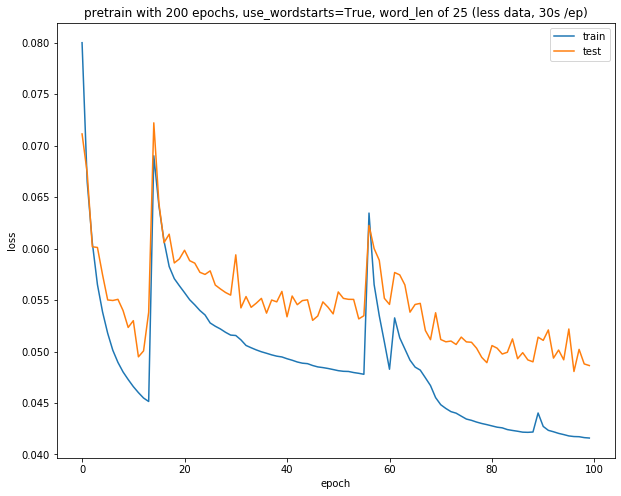

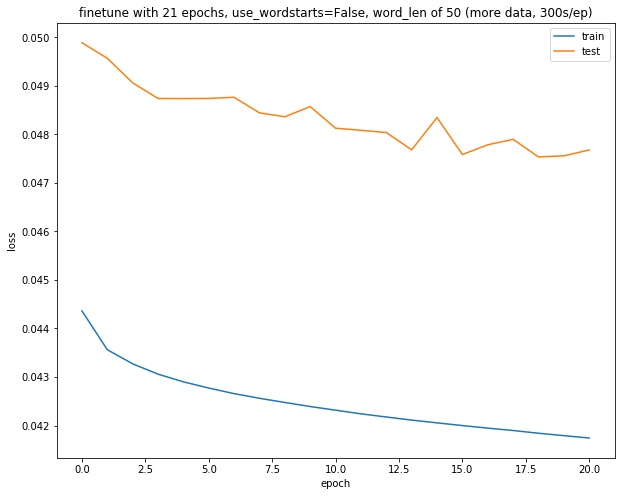

In [5]:
def visualize(history, title):
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(history[0])
    plt.plot(history[1])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["train", "test"])
    plt.title(title)
    plt.show()
    
visualize(history0, "pretrain with 100 epochs, use_wordstarts=True, word_len of 25 (less data, 30s /ep)")
visualize(history1, "finetune with 21 epochs, use_wordstarts=False, word_len of 50 (more data, 300s/ep)")

Training + test loss over time

<h2 style="color:rgb(0,120,170)">Text generation</h2>

To predict text, we want the option to deterministically predict the most probable text (greedily always take the most probable next char) or to non-deterministically sample one of the 5 most-probable characters with their respective chance given by the output of the network.

In [6]:
def generate(net: Model, inp: list, out_len: int, nr_pick=1, with_chances=True) -> list:
    inp = tensor([inp]).long().to(device).requires_grad_(False)  # wrap in list for batches
    for _ in range(out_len):
        out = net.forward(inp)[0]
        out = out.detach().cpu()  # transfer from gpu to cpu, so we can use it
        # take the last N options and randomly pick one of them
        if with_chances:
            best = out.argsort()[-nr_pick:]
            chances = out[best].numpy()
            nxt = tensor(np.random.choice(best, 1, p=chances/chances.sum()), requires_grad=False).to(device)
        else:
            nxt = out.argsort()[-nr_pick:]
            nxt = nxt[torch.randint(nr_pick,(1,))]
        
        nxt = torch.as_tensor(nxt).unsqueeze(0) # ..as_tensor
        inp = torch.cat((inp, nxt), 1)
    return inp[0, -out_len:].tolist()

for start_text in ["let me say ", "i think that ", "we should ", "i am the ", "the best ", "we should "]:
    print("\n"+start_text)
    for i in range(5):
        start_text_enc = transcoder.encode(start_text)
        gen_text_enc = generate(net, start_text_enc, 120, 5, with_chances=True)
        gen_text = transcoder.decode(gen_text_enc)
        print(gen_text.replace("\n", " ")[:gen_text.rindex(" ")]) # for nicer printing, cut half-words


let me say 
in people. they want to be tremendous to to tell to be a tride and the corerasion. what we're going to started all over
which it. and it stive out people. and who going to be the litered fumst of these people in the place. we always that
incredible. they dide they don't have to have all over that they want to tell you it was in serising the chapace than
and i would and the word in plant where the company. they'ls so here walking that a lot the people and we sort out and
i'm going to sill think then i would actueling a trayente anything on sorrars. we have and all of these some of thes

i think that 
is samizations. that's and it's not all terrination. you know. they differen about a plentiant on trus the wasn't say
than they didn't want tellicion. you said, and we said, "you knows than we do what when i think of that's alongs. we
the belistor. i talk an impigit out a great. and i'm the country, any doesn't be all, i do the wife are going to stop
are the country. they went 